In [1]:
import nibabel as nib
import matplotlib.pyplot as plt

In [2]:
image = nib.load('/cluster/projects/vc/data/mic/open/Prostate/PI-CAI/preped-images/images/imagesTr/10005_1000005.nii.gz').get_fdata()
label = nib.load('/cluster/projects/vc/data/mic/open/Prostate/PI-CAI/preped-images/images/labelsTr/10005_1000005.nii.gz').get_fdata()

In [7]:
print(image.shape)
print(label.shape)

(384, 384, 19, 3)
(384, 384, 19)


In [4]:
import numpy as np

print("Min value:", np.min(image))
print("Max value:", np.max(image))
print("Mean value:", np.mean(image))
print("Unique values:", np.unique(image))


Min value: 0.0
Max value: 3476.0
Mean value: 243.2140934815881
Unique values: [0.000e+00 1.000e+00 2.000e+00 ... 3.452e+03 3.472e+03 3.476e+03]


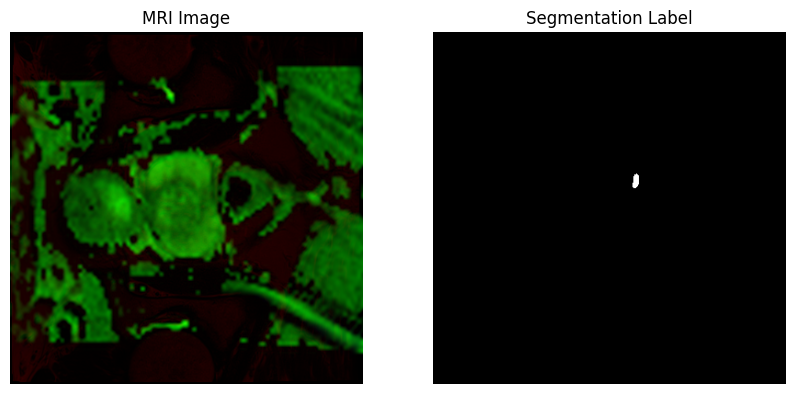

In [9]:
slice = 10
img_data = image[:, :, slice]
label_data = label[:, :, slice]

img_data = (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data))
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_data, cmap="gray")
axes[0].set_title("MRI Image")
axes[0].axis("off")

axes[1].imshow(label_data, cmap="gray")  
axes[1].set_title("Segmentation Label")
axes[1].axis("off")

plt.show()
